In [11]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import polars as pl
import pandas as pd
pd.set_option('display.float_format', lambda x: f'{x :.1f}')
from cleaner import DataCleaner
import numpy as np
from datetime import datetime
from tools import (
    order_and_rename,
    import_datasets,
    bins_generator
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
movies = pd.read_csv('clean_datasets/movies_clean.csv')
ratings = pd.read_csv(
    'movies_datasets/title_ratings.tsv',
    sep = "\t",
)
joined = pd.merge(
    movies,
    ratings,
    left_on = "titre_id",
    right_on = "tconst"
)

In [13]:
joined = joined.rename(
    columns={
        "averageRating" : "rating_avg",
        "numVotes" : "rating_votes"
    }
).drop("tconst", axis=1)

rating = joined

In [14]:
bins, names = bins_generator(rating["titre_date_sortie"].max())

rating["cuts"] = pd.cut(
    rating["titre_date_sortie"],
    bins=bins,
    labels=names
)

In [46]:
nodup = rating[~rating["titre_str"].duplicated(keep="first")]

In [47]:
nodup["rating_avg"].median()

6.3

In [48]:
nodup["rating_avg"].describe()

count   250676.0
mean         6.2
std          1.4
min          1.0
25%          5.4
50%          6.3
75%          7.1
max         10.0
Name: rating_avg, dtype: float64

In [49]:
condi = (
    nodup["rating_avg"] == 10
)

best_movies = nodup[condi]

best_movies

titre_id                                          titre_str  \
1311947  tt10449358                                            Kaputol   
1313085  tt10463270                                   Shouting Silence   
1327089  tt10663998     Widow of the Revolution: The Anna Larina Story   
1329972  tt10703554                                  The Book of Harth   
1344561  tt10925174                                  Petersburg's tram   
...             ...                                                ...   
2434689   tt8070536                         Dirt Merchants: Rebelistic   
2443030   tt8215820  Are We Making a Film? Behind the Scenes: Follo...   
2465969   tt8649490                                The Imaginary State   
2483251   tt8974670       Major Capers: The Legend of Team Broadminded   
2490333   tt9080346                           Poets Are the Destroyers   

        titre_type  titre_date_sortie  titre_date_fin  titre_duree  \
1311947      movie               2019               0          120   
1313085      movie               2021               0           95   
1327089      movie               2000               0            0   
1329972      movie               2022               0           62   
1344561      movie               2007               0           74   
...            ...                ...             ...          ...   
2434689      movie               2018               0           95   
2443030      movie               2018               0           67   
2465969      movie               2020               0          105   
2483251      movie               2022               0           88   
2490333      movie               2021               0            0   

                 titre_genres   person_id          person_name  \
1311947                 Drama   nm2921912            Popo Diaz   
1313085  Crime,Drama,Thriller  nm12297451          Samir Singh   
1327089           Documentary   nm8529806     Stephen F. Cohen   
1329972           Documentary   nm4495779  Timothy John Foster   
1344561   Documentary,History   nm7409140      Sergey Stepanov   
...                       ...         ...                  ...   
2434689                 Drama   nm4352839            Drew Lane   
2443030           Documentary   nm8332521  Adam William Cahill   
2465969        Drama,Thriller   nm0592164       Miguel Miranda   
2483251           Documentary   nm0589719     Michael Millikan   
2490333                 Drama   nm9684744         Aarushi Agni   

         person_birthdate           person_job                   person_role  \
1311947                 0  production_designer                             0   
1313085                 0                actor                    ["Tushar"]   
1327089                 0                actor  ["Narrator & Correspondent"]   
1329972                 0      cinematographer                             0   
1344561                 0                 self               ["Self - Host"]   
...                   ...                  ...                           ...   
2434689                 0             composer                             0   
2443030              1986                 self                      ["Self"]   
2465969                 0             composer                             0   
2483251                 0      cinematographer                             0   
2490333                 0              actress               ["Jazz Singer"]   

         person_index  rating_avg  rating_votes       cuts  
1311947            10        10.0             7  2010-2020  
1313085            10        10.0            18  2010-2020  
1327089             1        10.0            25  1990-2000  
1329972            10        10.0             8      >2021  
1344561             1        10.0            27  2000-2010  
...               ...         ...           ...        ...  
2434689            10        10.0             7  2010-2020  
2443030             1        10.0      

In [50]:
for date in names[1:]:
    condi = (
        (nodup["cuts"] == date)
    )


    print(f"Average note for {date}, {nodup['rating_avg'][condi].median()}")

Average note for 1900-1920, 6.0
Average note for 1920-1940, 6.2
Average note for 1940-1960, 6.3
Average note for 1960-1980, 6.1
Average note for 1980-1990, 6.1
Average note for 1990-2000, 6.2
Average note for 2000-2010, 6.4
Average note for 2010-2020, 6.4
Average note for >2021, 6.7


In [51]:
condi = nodup["rating_avg"] > nodup["rating_avg"].median()

nodup["titre_genres"][condi].mode()

0    Documentary
Name: titre_genres, dtype: object

In [43]:
# films avec note au dessus de la moyenne et nb de vote > au 3e quartile
condi = (
    (nodup["rating_avg"] > nodup["rating_avg"].median()) &
    (nodup["rating_votes"] > 413)
)
nodup[condi].reset_index(drop='index')

titre_id                                  titre_str titre_type  \
0      tt0002130                            Dante's Inferno      movie   
1      tt0002423                                    Passion      movie   
2      tt0002646                                   Atlantis      movie   
3      tt0002844  Fantômas: In the Shadow of the Guillotine      movie   
4      tt0003014                              Ingeborg Holm      movie   
...          ...                                        ...        ...   
26512  tt9900782                                     Kaithi      movie   
26513  tt9902160                                    Herself      movie   
26514  tt9904844                       Ott Tänak: The Movie      movie   
26515  tt9905462                                  Pengalila      movie   
26516  tt9911196                        The Marriage Escape      movie   

       titre_date_sortie  titre_date_fin  titre_duree  \
0                   1911               0           71   
1                   1919               0           85   
2                   1913               0          121   
3                   1913               0           54   
4                   1913               0           96   
...                  ...             ...          ...   
26512               2019               0          145   
26513               2020               0           97   
26514               2019               0          125   
26515               2019               0          111   
26516               2020               0          103   

                  titre_genres  person_id      person_name  person_birthdate  \
0      Adventure,Drama,Fantasy  nm1376180  Sandro Properzi                 0   
1      Biography,Drama,Romance  nm0913298   Kurt Waschneck              1882   
2                        Drama  nm0004592    Robert Israel              1963   
3                  Crime,Drama  nm1666136   Georges Guérin                 0   
4                        Drama  nm0526234     Richard Lund              1885   
...                        ...        ...              ...               ...   
26512   Action,Adventure,Crime  nm4237148         Sam C.S.                 0   
26513                    Drama  nm2570742     Natalie Holt                 0   
26514        Documentary,Sport  nm2761473      Margus Malm                 0   
26515                    Drama  nm4143605    V.T. Sreejith                 0   
26516             Comedy,Drama  nm8946897    Daniël Polman                 0   

                person_job              person_role  person_index  rating_avg  \
0      production_designer                        0            10         7.0   
1          cinematographer                        0            10         6.6   
2                 composer                        0            10         6.5   
3          cinematographer                        0            10         6.9   
4                    actor  ["Doctor at Poorhouse"]            10         7.0   
...                    ...                      ...           ...         ...   
26512             composer                        0            10         8.4   
26513             composer                        0            10         7.0   
26514      cinematographer                        0            10         8.1   
26515               editor                        0            10         7.6   
26516             composer                        0            10         7.5   

       rating_votes       cuts  
0              3267  1900-1920  
1               968  1900-1920  
2               459  1900-1920  
3              2426  1900-1920  
4              1368  1900-1920  
...             ...        ...  
26512         38145  2010-2020  
26513          4436  2010-2020  
26514           498  2010-2020  
26515           679  2010-2020  
26516          3166  2010-2020  

[26517 rows x 16 columns]

Avg rating par genre, avg rating par acteur, avg par director, correlation entre durée et note?

In [59]:
# avg rating par director
# rajouter le nb de film a coté

condi = rating[rating["person_job"] == "director"]

director_avg = condi.groupby('person_name')["rating_avg"].mean().reset_index()

director_avg = director_avg.sort_values(by="rating_avg", ascending=False)

director_avg

person_name  rating_avg
729     Abraham Escobedo Salas        10.0
77792                Nancy Pop        10.0
101972        Stephen Adetumbi        10.0
17846          Charley Voorhis        10.0
28150          Drayon Blackett        10.0
...                        ...         ...
45146               Jack Wells         1.0
115261               Yunsu Kim         1.0
59210             Kenta Matsuo         1.0
75456             Mikio Ohkado         1.0
113193         William Karfiol         1.0

[116689 rows x 2 columns]

In [65]:
# avg par acteur
# rajouter le nb de film a coté

condi = rating[rating["person_job"].str.contains("act")]

actor_avg = condi.groupby('person_name')["rating_avg"].mean().reset_index()

actor_avg = actor_avg.sort_values(by="rating_avg", ascending=False)

actor_avg

person_name  rating_avg
314681         Ruchika Bhatia        10.0
32763              Arne Pelto        10.0
234309         Marilyn Bevans        10.0
109185       Esme Grey Moffat        10.0
251173         Michael Rooney        10.0
...                       ...         ...
96773                   Dyler         1.0
6037    Aida Fuentes Concheso         1.0
65724       Chisato Hashimoto         1.0
13416            Alfred Kjøge         1.0
126804                Gia Bao         1.0

[391467 rows x 2 columns]

<Axes: xlabel='titre_duree', ylabel='rating_avg'>

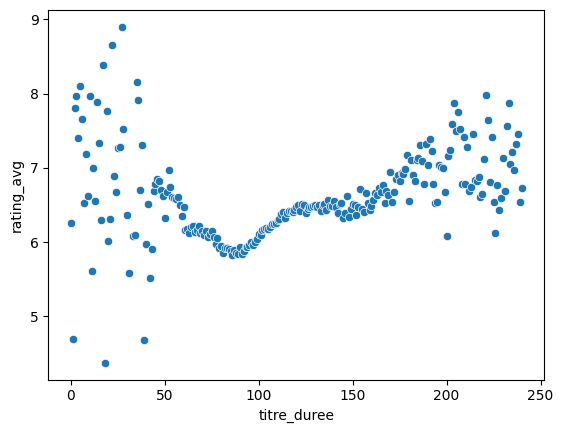

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

condi = rating[rating["titre_duree"] <= 240]

duration_avg_rating = condi.groupby('titre_duree')['rating_avg'].mean().reset_index()

correlation = duration_avg_rating['titre_duree'].corr(duration_avg_rating['rating_avg'])

sns.scatterplot(x='titre_duree', y='rating_avg', data=duration_avg_rating)